### Высокая длительность операции

/var/folders/v5/41v6d3yd1mq_zlsl4h4bncf00000gn/T/ipykernel_31881/523699098.py:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


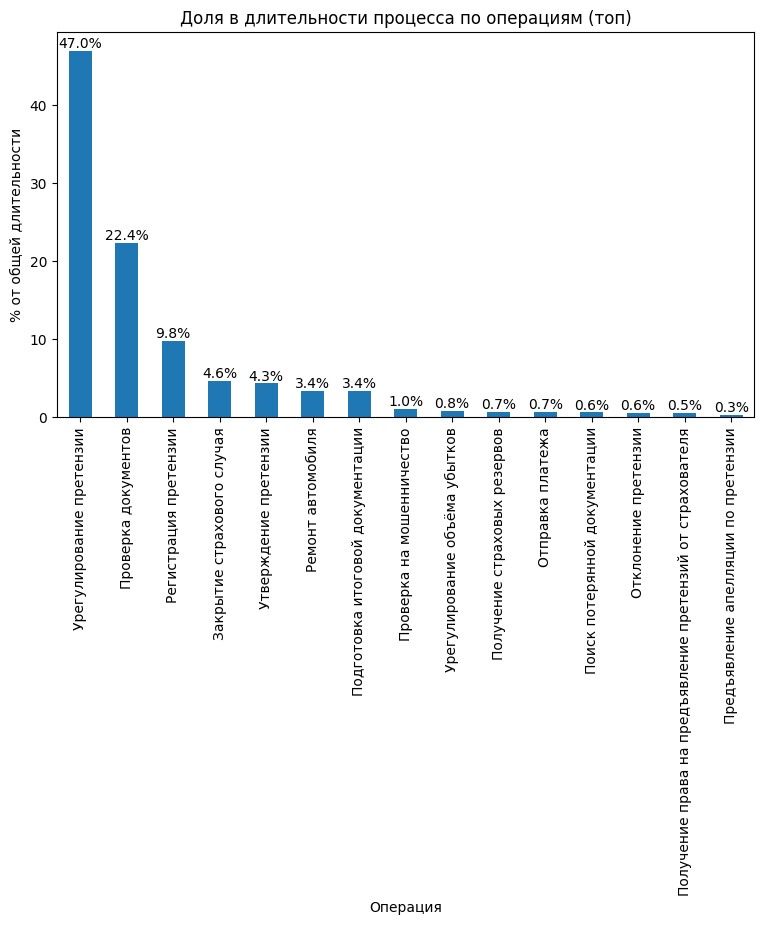

,Событие,Количество,Сумма_сек,Средняя_сек,Медиана_сек,Стд_откл_сек,Доля_в_процессе_%,mean/median,std_norm,Гипотеза_узкого_места,Потенциальный_эффект_валюта
0,Урегулирование претензии,59630,2.753353e+09,46173.948348,54000.0,31427.293737,47.02,0.855073,6.135654,False,6.686224e+08
1,Проверка документов,56482,1.308378e+09,23164.505152,28800.0,15796.801125,22.35,0.804323,3.084062,False,3.179760e+08
2,Регистрация претензии,49873,5.750356e+08,11529.998596,14400.0,8006.747473,9.82,0.800694,1.563184,False,1.424190e+08
3,Закрытие страхового случая,49873,2.691972e+08,5397.654041,3600.0,1800.016517,4.60,1.499348,0.351423,False,3.740469e+07
4,Утверждение претензии,46912,2.533140e+08,5399.769782,3600.0,1800.019170,4.33,1.499936,0.351424,False,3.518400e+07
5,Ремонт автомобиля,36383,1.963116e+08,5395.695792,3600.0,1800.019591,3.35,1.498804,0.351424,False,2.728709e+07
6,Подготовка итоговой документации,36383,1.961244e+08,5390.550532,3600.0,1799.999933,3.35,1.497375,0.351420,False,2.728650e+07
7,Проверка на мошенничество,11002,5.976360e+07,5432.066897,7200.0,1799.796138,1.02,0.754454,0.351380,False,8.248881e+06
8,Урегулирование объёма убытков,9029,4.865040e+07,5388.237900,3600.0,1800.061255,0.83,1.496733,0.351432,False,6.771461e+06
9,Получение страховых резервов,7523,4.074840e+07,5416.509371,7200.0,1800.043928,0.70,0.752293,0.351429,False,5.641775e+06


In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- настройки ---
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

INPUT_FILE = "case_championship_last.csv"   # <-- укажи свой файл
COST_PER_MIN = 50.0
SHOW_ALL = True
TOP_N = 16          # если SHOW_ALL=False
MIN_SHARE = 0.0

# ---------- загрузка данных ----------
df = pd.read_csv(INPUT_FILE, encoding="utf-8-sig")   # или pd.read_excel
df["Время"] = pd.to_datetime(df["Время"], utc=True, errors="coerce")
df = df.sort_values(["ID", "Время"]).reset_index(drop=True)

# ---------- длительности операций ----------
df["Следующее_время"] = df.groupby("ID")["Время"].shift(-1)
df["Длительность_сек"] = (df["Следующее_время"] - df["Время"]).dt.total_seconds()
dur = df.dropna(subset=["Длительность_сек"]).copy()

# ---------- агрегирование ----------
agg = (
    dur.groupby("Событие")["Длительность_сек"]
    .agg(["count","sum","mean","median","std"])
    .rename(columns={"count":"Количество","sum":"Сумма_сек",
                     "mean":"Средняя_сек","median":"Медиана_сек","std":"Стд_откл_сек"})
    .sort_values("Сумма_сек", ascending=False)
)

total = agg["Сумма_сек"].sum()
agg["Доля_в_процессе_%"] = (agg["Сумма_сек"] / max(total,1) * 100).round(2)

mean_overall_std = agg["Стд_откл_сек"].dropna().mean()
agg["mean/median"] = agg["Средняя_сек"] / agg["Медиана_сек"]
agg["std_norm"] = agg["Стд_откл_сек"] / mean_overall_std if pd.notna(mean_overall_std) else np.nan
q75 = agg["Средняя_сек"].quantile(0.75)
agg["Гипотеза_узкого_места"] = (
    (agg["Средняя_сек"] >= q75) &
    (agg["mean/median"].between(0.9, 1.1)) &
    (agg["std_norm"] < 0.5)
)

# ---------- потенциальный эффект ----------
excess = dur.merge(agg[["Средняя_сек"]], left_on="Событие", right_index=True)
excess["Превышение_сек"] = (excess["Длительность_сек"] - excess["Средняя_сек"]).clip(lower=0)
agg["Потенциальный_эффект_валюта"] = (
    excess.groupby("Событие")["Превышение_сек"].sum() / 60.0 * COST_PER_MIN
).reindex(agg.index).fillna(0).round(2)

# ---------- графики ----------
# 1. Доля в длительности процесса + подписи процентов (оставляем)
plt.figure(figsize=(9,5))
bars = agg["Доля_в_процессе_%"].head(TOP_N).plot(kind="bar")
plt.title("Доля в длительности процесса по операциям (топ)")
plt.xlabel("Операция")
plt.ylabel("% от общей длительности")
for i, p in enumerate(bars.patches):
    val = agg["Доля_в_процессе_%"].head(TOP_N).iloc[i]
    bars.annotate(f"{val:.1f}%",
                  (p.get_x() + p.get_width() / 2, p.get_height()),
                  ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()


# ---------- итоговая таблица ----------
display(agg.reset_index().rename(columns={"index":"Событие"}))


### Многократные инциденты высокой длительности процессов и Bottleneck

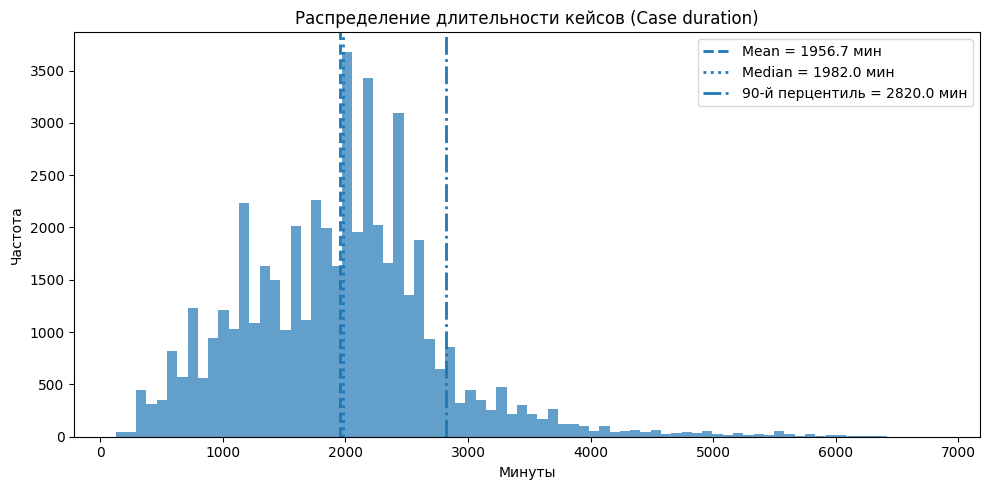

Кейсов всего: 49873, медленных (>= p90): 5157


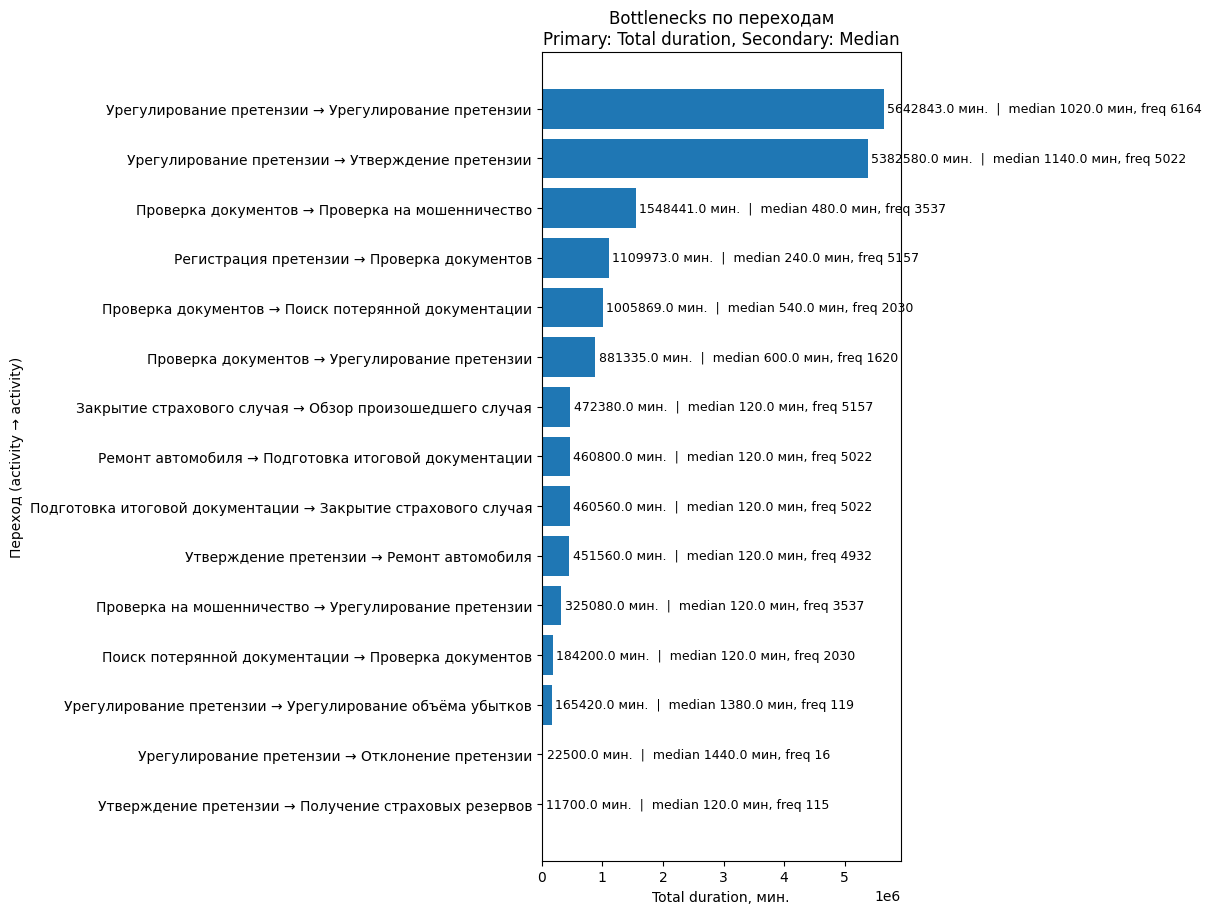

Top-15 переходов покрывают 99.7% суммарной длительности задержек среди медленных кейсов.


,Edge,Freq,Total_min,Mean_min,Median_min,Total_disp
0,Урегулирование претензии → Урегулирование прет...,6164,5642843.0,915.451493,1020.0,5642843.0
1,Урегулирование претензии → Утверждение претензии,5022,5382580.0,1071.800080,1140.0,5382580.0
2,Проверка документов → Проверка на мошенничество,3537,1548441.0,437.783715,480.0,1548441.0
3,Регистрация претензии → Проверка документов,5157,1109973.0,215.236184,240.0,1109973.0
4,Проверка документов → Поиск потерянной докумен...,2030,1005869.0,495.501970,540.0,1005869.0
5,Проверка документов → Урегулирование претензии,1620,881335.0,544.033951,600.0,881335.0
6,Закрытие страхового случая → Обзор произошедше...,5157,472380.0,91.599767,120.0,472380.0
7,Ремонт автомобиля → Подготовка итоговой докуме...,5022,460800.0,91.756272,120.0,460800.0
8,Подготовка итоговой документации → Закрытие ст...,5022,460560.0,91.708483,120.0,460560.0
9,Утверждение претензии → Ремонт автомобиля,4932,451560.0,91.557178,120.0,451560.0



Выбранный переход (узкое место): Урегулирование претензии → Урегулирование претензии
Наблюдений: 6164 | Mean: 915.45 мин | Median: 1020.00 мин
Потенциальный эффект: 54,316,798.32 (S=50.0 за минуту)


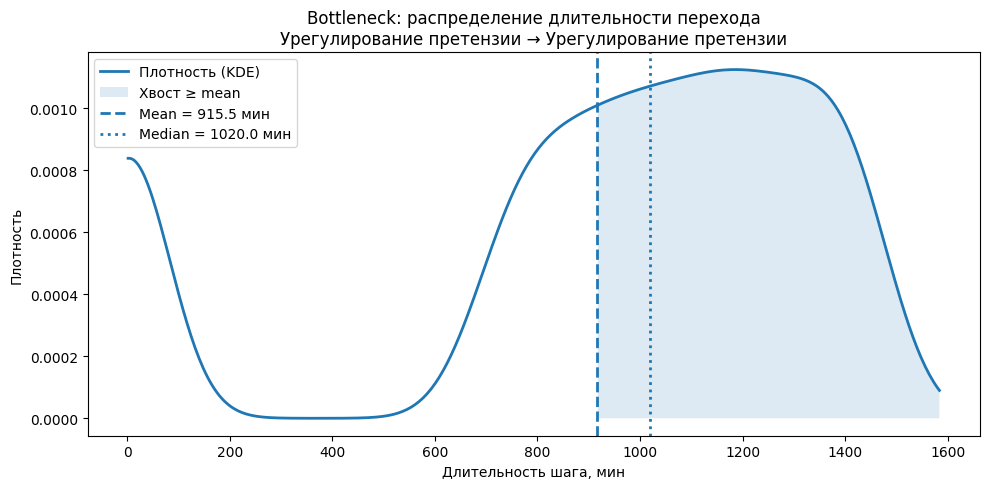

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from IPython.display import display

# ========= ПАРАМЕТРЫ (редактируй под себя) =========
INPUT_FILE = "case_championship_last.csv"     # CSV или XLSX
SLOW_CASES_PERCENTILE = 0.90                  # порог «медленных» кейсов, например 0.9
TOP_EDGES = 15                                # сколько показать «узких» переходов
EDGE_UNITS = "min"                            # "min" или "h"

# Параметры для оценки эффекта на выбранном переходе (вторая визуализация)
S_COST_PER_MIN = 50.0                         # стоимость 1 минуты процесса
SELECT_EDGE = None                            # можно указать конкретный переход "A → B"; None = выбрать автоматически

# ========= ЗАГРУЗКА И ПОДГОТОВКА =========
if INPUT_FILE.lower().endswith((".xlsx", ".xls")):
    df = pd.read_excel(INPUT_FILE)
else:
    df = pd.read_csv(INPUT_FILE, encoding="utf-8-sig")

# важно: колонка "Время" — Timestamp; сортировка внутри кейса
df["Время"] = pd.to_datetime(df["Время"], utc=True, errors="coerce")
df = df.sort_values(["ID","Время"]).reset_index(drop=True)

# длительность шага (между событиями одной трассы)
df["Время_след"] = df.groupby("ID")["Время"].shift(-1)
df["StepDur_min"] = (df["Время_след"] - df["Время"]).dt.total_seconds() / 60.0

# полная длительность кейса (от первого до последнего события)
case_span = (
    df.groupby("ID")["Время"]
      .agg(["min","max"])
      .assign(CaseDur_min=lambda x: (x["max"]-x["min"]).dt.total_seconds()/60.0)
)

# присоединим длительность кейса к строкам событий
df = df.merge(case_span["CaseDur_min"], left_on="ID", right_index=True, how="left")

# ========= 1) CASE DURATION: распределение + фильтр медленных =========
plt.figure(figsize=(10,5))

case_durs = case_span["CaseDur_min"].dropna().to_numpy()
bins = max(20, min(80, int(np.sqrt(max(len(case_durs),1))*2)))
plt.hist(case_durs, bins=bins, alpha=0.7)

p = np.quantile(case_durs, SLOW_CASES_PERCENTILE) if len(case_durs) else 0.0
mean_cd = float(np.mean(case_durs)) if len(case_durs) else 0.0
med_cd  = float(np.median(case_durs)) if len(case_durs) else 0.0

plt.axvline(mean_cd, ls="--", lw=2, label=f"Mean = {mean_cd:.1f} мин")
plt.axvline(med_cd,  ls=":",  lw=2, label=f"Median = {med_cd:.1f} мин")
plt.axvline(p,       ls="-.", lw=2, label=f"{int(SLOW_CASES_PERCENTILE*100)}-й перцентиль = {p:.1f} мин")

plt.title("Распределение длительности кейсов (Case duration)")
plt.xlabel("Минуты")
plt.ylabel("Частота")
plt.legend()
plt.tight_layout()
plt.show()

slow_ids = set(case_span.index[case_span["CaseDur_min"] >= p])
print(f"Кейсов всего: {len(case_span)}, медленных (>= p{int(SLOW_CASES_PERCENTILE*100)}): {len(slow_ids)}")

# ========= 2) EDGE PERFORMANCE (Total duration + Median в подписи) =========
# Фокус: только «медленные» кейсы, чтобы понять где именно теряется время
slow_df = df[df["ID"].isin(slow_ids)].copy()

# имена событий текущего и следующего шага
slow_df["Событие_след"] = slow_df.groupby("ID")["Событие"].shift(-1)

# оставляем валидные переходы
edges = slow_df.dropna(subset=["Событие","Событие_след","StepDur_min"]).copy()
edges["Edge"] = edges["Событие"] + " → " + edges["Событие_след"]

edge_agg = (
    edges.groupby("Edge")["StepDur_min"]
         .agg(["count","sum","mean","median"])
         .rename(columns={"count":"Freq","sum":"Total_min","mean":"Mean_min","median":"Median_min"})
         .sort_values("Total_min", ascending=False)
)

# единицы измерения для оси Х
if EDGE_UNITS.lower().startswith("h"):
    edge_agg["Total_disp"] = (edge_agg["Total_min"] / 60.0)
    units_label = "час."
else:
    edge_agg["Total_disp"] = edge_agg["Total_min"]
    units_label = "мин."

# Горизонтальный барчарт: основная метрика — Total duration, вторичная — Median
plot_df = edge_agg.head(TOP_EDGES).iloc[::-1]  # сверху — самый большой
fig_h = max(3.5, 0.55*max(len(plot_df), 1)+1)
plt.figure(figsize=(12, fig_h))
bars = plt.barh(plot_df.index, plot_df["Total_disp"])

plt.title("Bottlenecks по переходам\nPrimary: Total duration, Secondary: Median")
plt.xlabel(f"Total duration, {units_label}")
plt.ylabel("Переход (activity → activity)")

# подписи справа от столбцов
if len(plot_df):
    for rect, (_, row) in zip(bars, plot_df.iterrows()):
        x = rect.get_width()
        y = rect.get_y() + rect.get_height()/2
        label = f"{row['Total_disp']:.1f} {units_label}  |  median {row['Median_min']:.1f} мин, freq {int(row['Freq'])}"
        plt.text(x + max(plot_df["Total_disp"].max()*0.01, 0.1), y, label, va="center", fontsize=9)

plt.tight_layout()
plt.show()

# Pareto-покрытие топ-N
coverage = (plot_df["Total_min"].sum() / edge_agg["Total_min"].sum() * 100) if len(edge_agg) else 0.0
print(f"Top-{TOP_EDGES} переходов покрывают {coverage:.1f}% суммарной длительности задержек среди медленных кейсов.")

# Таблица для экспорта/просмотра
display(edge_agg.reset_index().rename(columns={"index":"Edge"}))

# ========= 3) BOTTLENECK KDE: распределение длительности выбранного перехода =========
# Выбор перехода: явный SELECT_EDGE или автоматический — с максимальной суммарной задержкой
if len(edge_agg) == 0:
    print("Недостаточно данных для построения KDE по переходу (нет валидных переходов среди медленных кейсов).")
else:
    if SELECT_EDGE and (SELECT_EDGE in edge_agg.index):
        edge_name = SELECT_EDGE
    else:
        edge_name = edge_agg.index[0]

    sample = edges.loc[edges["Edge"]==edge_name, "StepDur_min"].dropna().to_numpy()

    if len(sample) == 0:
        print(f"Для перехода '{edge_name}' нет наблюдений.")
    else:
        mu  = float(sample.mean())
        med = float(np.median(sample))
        # потенциальный эффект: сумма превышений над средним, умноженная на стоимость S
        excess_minutes = float(np.clip(sample - mu, 0, None).sum())
        potential_effect = excess_minutes * S_COST_PER_MIN

        print(f"\nВыбранный переход (узкое место): {edge_name}")
        print(f"Наблюдений: {len(sample)} | Mean: {mu:.2f} мин | Median: {med:.2f} мин")
        print(f"Потенциальный эффект: {potential_effect:,.2f} (S={S_COST_PER_MIN} за минуту)")

        # ВИЗУАЛИЗАЦИЯ KDE
        plt.figure(figsize=(10,5))

        # KDE-плотность
        kde = gaussian_kde(sample)
        xs = np.linspace(max(0.0, sample.min()*0.9), sample.max()*1.1, 400)
        ys = kde(xs)
        plt.plot(xs, ys, lw=2, label="Плотность (KDE)")

        # подсветим правый хвост (t >= mean)
        mask = xs >= mu
        plt.fill_between(xs[mask], 0, ys[mask], alpha=0.15, label="Хвост ≥ mean")

        # линии среднего и медианы
        plt.axvline(mu,  ls="--", lw=2, label=f"Mean = {mu:.1f} мин")
        plt.axvline(med, ls=":",  lw=2, label=f"Median = {med:.1f} мин")

        plt.title(f"Bottleneck: распределение длительности перехода\n{edge_name}")
        plt.xlabel("Длительность шага, мин")
        plt.ylabel("Плотность")
        plt.legend()
        plt.tight_layout()
        plt.show()


### Зависимость между длительностью процесса и времени (не найдена)

/var/folders/v5/41v6d3yd1mq_zlsl4h4bncf00000gn/T/ipykernel_31881/2634138999.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  case_span["StartMonth"] = case_span["min"].dt.to_period("M").apply(lambda r: r.start_time.date())


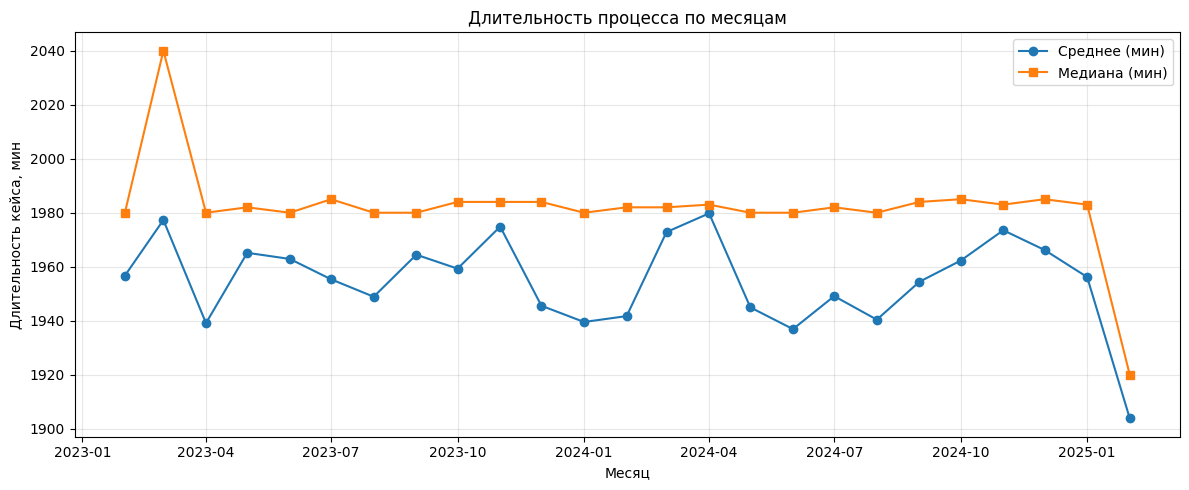

In [5]:
# === группировка по месяцам ===
case_span["StartMonth"] = case_span["min"].dt.to_period("M").apply(lambda r: r.start_time.date())

monthly_stats = (
    case_span.groupby("StartMonth")["CaseDur_min"]
             .agg(Mean="mean", Median="median", Count="count")
             .reset_index()
)

plt.figure(figsize=(12,5))
plt.plot(monthly_stats["StartMonth"], monthly_stats["Mean"], marker="o", label="Среднее (мин)")
plt.plot(monthly_stats["StartMonth"], monthly_stats["Median"], marker="s", label="Медиана (мин)")
plt.title("Длительность процесса по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Длительность кейса, мин")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
